C:\Users\bongkyun\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.007327502127736807
Epoch [20/100], Loss: 0.006209179759025574
Epoch [30/100], Loss: 0.004869019612669945
Epoch [40/100], Loss: 0.0035413752775639296
Epoch [50/100], Loss: 0.0024797883816063404
Epoch [60/100], Loss: 0.001775070559233427
Epoch [70/100], Loss: 0.0013628435553982854
Epoch [80/100], Loss: 0.001136489911004901
Epoch [90/100], Loss: 0.001014126930385828
Epoch [100/100], Loss: 0.0009472527308389544


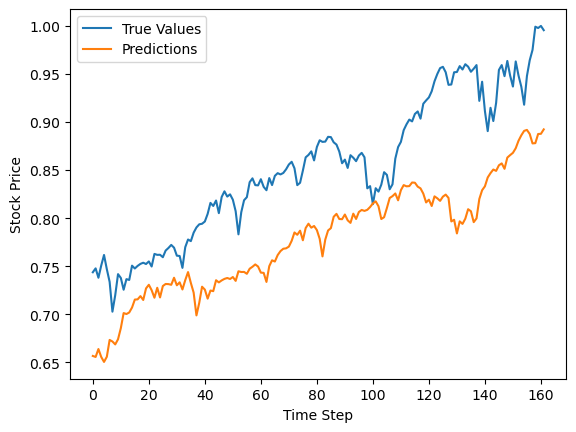

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Load the stock data
df = pd.read_csv('../price_universe.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.iloc[:, :1]

# Preprocess the data
scaler = MinMaxScaler()
df['S&P 500'] = scaler.fit_transform(df[['S&P 500']])

# Convert the data into a time series format
def create_time_series(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30
data = df['S&P 500'].values
data = data.reshape(-1, 1)
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[:train_size, :], data[train_size:, :]
X_train, y_train = create_time_series(train_data, look_back)
X_test, y_test = create_time_series(test_data, look_back)

# Convert the data into tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        x = self.fc(x[-1, :, :])
        return x

# Instantiate the model
input_size = 1
hidden_size = 128
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for i in range(X_train.size(0)):
        x = X_train[i].view(1, look_back, input_size)
        y = y_train[i].view(1, 1)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        
import matplotlib.pyplot as plt

# Get the predictions
predictions = []
model.eval()
for i in range(len(X_test)):
    x = X_test[i].view(1, look_back, input_size)
    predictions.append(model(x).detach().numpy()[0, 0])

# Plot the predictions and the true values
plt.plot(y_test.numpy(), label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()